# Customer Revenue Prediction

## Exploratory Data Analysis
*Machine Learning Nanodegree Program | Capstone Project*

---

In this notebook I will be exploring the dataset, noting patterns about the data points and distribution of the dataset.

### Overview:
- Reading the data
- Filling in the missing data
- Analyzing the dataset
- Removing the constant value columns
- Normalizing the dataset 
- Spliting the data into training, validation and test sets
- Saving the files

### Dataset:
The dataset is download from the [Kaggle competetion](https://www.kaggle.com/c/ga-customer-revenue-prediction/overview) Google Analytics Customer Revenue Prediction.

#### Initial Data:
- **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping** - The channel via which the user came to the Store.
- **date** - The date on which the user visited the Store.
- **sessionId** - The sessionId of the user visited the Store.
- **device** - The specifications for the device used to access the Store.
- **geoNetwork** - This section contains information about the geography of the user.
- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals** - This section contains aggregate values across the session.
- **trafficSource** - This section contains information about the Traffic Source from which the session originated.
- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime** - The timestamp (expressed as POSIX time).
---

### Loading and formatting Data

First, import the relevant libraries into notebook

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import squarify
import plotly.graph_objs as go 

from os import path
from datetime import datetime
from dateutil.parser import parse
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from plotly.offline import iplot, plot 
from pandas.io.json import json_normalize

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.10f' % x)

Set the various paths for the files that are used for reading and writing the data

In [2]:
data_dir = '../datasets'

if not path.exists(data_dir):
    raise Exception('{} directory not found.'.format(data_dir))

raw_train_file = '{}/{}'.format(data_dir, 'raw_train.zip')
print('\nRaw Train file: {}'.format(raw_train_file))

raw_test_file = '{}/{}'.format(data_dir, 'raw_test.zip')
print('\nRaw Test file: {}'.format(raw_test_file))

train_file = '{}/{}'.format(data_dir, 'train.zip')
print('\nTrain file: {}'.format(train_file))

val_file = '{}/{}'.format(data_dir, 'val.zip')
print('\nValidation file: {}'.format(val_file))

test_file = '{}/{}'.format(data_dir, 'test.zip')
print('\nTest file: {}'.format(test_file))


Raw Train file: ../datasets/raw_train.zip

Raw Test file: ../datasets/raw_test.zip

Train file: ../datasets/train.zip

Validation file: ../datasets/val.zip

Test file: ../datasets/test.zip


Some of the columns in the intial data are JSON objects. We need to serialize them so as to access the various data points in the JSON object.

In [3]:
def load_data(data_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(
        data_path,
        converters={column: json.loads for column in JSON_COLUMNS},
        dtype={'fullVisitorId': 'str'},
        compression='zip'
    )

    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f'{column}.{subcolumn}' for subcolumn in column_as_df.columns]

        df.drop(column, axis=1, inplace=True)
        df = df.merge(column_as_df, right_index=True, left_index=True)

    [rows, columns] = df.shape

    print('Loaded {} rows with {} columns from {}.'.format(
        rows, columns, data_path
    ))
    
    return df

In [4]:
%%time 

train_df = load_data(raw_train_file)
test_df = load_data(raw_test_file)
print()

Loaded 903653 rows with 55 columns from ../datasets/raw_train.zip.
Loaded 804684 rows with 53 columns from ../datasets/raw_test.zip.

CPU times: user 4min 25s, sys: 24.9 s, total: 4min 50s
Wall time: 5min 54s


After the import and transformation, we have 55 columns.
Now, lets see our data and handle them

In [5]:
print('Transactions Minimum Date: {}'.format(train_df['date'].min()))
print('Transactions Maximum Date: {}\n'.format(train_df['date'].max()))
train_df.head()

Transactions Minimum Date: 20160801
Transactions Maximum Date: 20170801



,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [6]:
%%time 

total_null_sum = train_df.isnull().sum()
total_null_count = train_df.isnull().count()

train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')

dfgv_id = train_df.groupby('fullVisitorId')
dfgv_id = dfgv_id['totals.transactionRevenue'].sum().reset_index()

total = total_null_sum.sort_values(ascending=False)
percent = (total_null_sum / total_null_count * 100)
percent = percent.sort_values(ascending=False)

df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

rows = train_df.shape[0]
uniq_rows = dfgv_id.shape[0]
uniq_visitors = train_df['fullVisitorId'].nunique()
    
nzi = pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr = (dfgv_id['totals.transactionRevenue'] > 0).sum()

print('\n{} unique customers in train set. Ratio: {}.'.format(uniq_visitors, (uniq_visitors / rows)))
print('{} instances have non-zero revenue out of {}. Ratio: {}.'.format(nzi, rows, (nzi / rows)))
print('{} unique customers with non-zero revenue out of {}. Ratio: {}.'.format(nzr, uniq_rows, (nzr / uniq_rows)))
print('{} number of common visitors in train and test set.'.format(
    len(set(train_df['fullVisitorId'].unique()).intersection(set(test_df['fullVisitorId'].unique())))
))

print('\nTotal columns with at least one Values:')
print(df[~(df['Total'] == 0)])
print()


714167 unique customers in train set. Ratio: 0.7903111039303804.
11515 instances have non-zero revenue out of 903653. Ratio: 0.0127427231470487.
9996 unique customers with non-zero revenue out of 714167. Ratio: 0.013996726255903731.
7679 number of common visitors in train and test set.

Total columns with at least one Values:
                                               Total       Percent
trafficSource.campaignCode                    903652 99.9998893381
trafficSource.adContent                       892707 98.7886943329
totals.transactionRevenue                     892138 98.7257276853
trafficSource.adwordsClickInfo.page           882193 97.6251946267
trafficSource.adwordsClickInfo.adNetworkType  882193 97.6251946267
trafficSource.adwordsClickInfo.slot           882193 97.6251946267
trafficSource.adwordsClickInfo.isVideoAd      882193 97.6251946267
trafficSource.adwordsClickInfo.gclId          882092 97.6140177701
trafficSource.isTrueDirect                    629648 69.6780733312
t

From the above results we see that some columns have null values. We will be defaulting the values for the columns that have less than 90% null values and remove the columns that have more than 90% null values

In [ ]:
print('\nOriginal Dataframe Info:\n')

print(train_df.info())
print()

In [7]:
%%time

na_val_keys = {
    'totals.pageviews': [1, 'int'],
    'totals.newVisits': [0, 'int'],
    'totals.bounces': [0, 'int'],
    'totals.transactionRevenue': [0, 'float'],
    'trafficSource.isTrueDirect': [False, 'bool'],
    'trafficSource.referralPath': ['N/A', 'str']
}

for nav_k, [nav_v, nav_t] in na_val_keys.items():
    train_df[nav_k] = train_df[nav_k].fillna(nav_v)
    train_df[nav_k] = train_df[nav_k].astype(nav_t)
    
    if nav_k != 'totals.transactionRevenue':
        test_df[nav_k] = test_df[nav_k].fillna(nav_v)
        test_df[nav_k] = test_df[nav_k].astype(nav_t)
    
na_vals = [
    'unknown.unknown', '(not set)', 'not available in demo dataset', 
    '(not provided)', '(none)', '<NA>', 'nan'
]

for na_val in na_vals:
    train_df = train_df.replace(na_val, 'N/A')
    test_df = test_df.replace(na_val, 'N/A')

CPU times: user 1min 24s, sys: 15.5 s, total: 1min 40s
Wall time: 2min 9s


There may be some columns that have unique values which may not be useful in our model training. So we need to remove those columns along with the columns that have 90% of values as null. 

In [8]:
%%time

const_cols = [
    c
    for c in train_df.columns
    if train_df[c].nunique(dropna=False) == 1
]

const_cols += [
    'sessionId', 'visitId', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd',
]

cols_not_in_test = set(train_df.columns).difference(set(test_df.columns))

train_const_cols = const_cols + ['trafficSource.campaignCode']

train_df.drop(train_const_cols, axis=1, inplace=True)
test_df.drop(const_cols, axis=1, inplace=True)

print('\nTrain features dropped: {}'.format(len(train_const_cols)))
print('\nTest features dropped: {}'.format(len(const_cols)))

print('\nTrain Shape after dropping: {}'.format(train_df.shape))
print('\nTest Shape after dropping: {}\n'.format(test_df.shape))


Total Train Features dropped : ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'sessionId', 'visitId', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode']

Train features dropped: 28

Total Test Features dropped : ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'devic

In [ ]:
print(train_df.info())
print()

### Visualizations

Let us visualize some patterns between the various features.


#### Revenue Distribution 

In [414]:
def get_total_revenue(feature, filter_percent=False):
    total_revenue = date_df['totals.transactionRevenue'].sum()

    df = train_df.groupby(by=[feature]).agg({'totals.transactionRevenue': 'sum'}).reset_index()
    df = df.sort_values(by='totals.transactionRevenue', ascending=False)
    df['percent'] = (df['totals.transactionRevenue'] / total_revenue) * 100

    if filter_percent is True:
        filter_len = len(df[df['percent'] == 0])
        df = df[(df[['percent']] > 1).all(axis=1)]

        df = df.append(
            {
                feature : 'Others({})'.format(filter_len), 
                'percent' : 0.0, 
                'totals.transactionRevenue': 0.0
            }, 
            ignore_index=True
        )
        
    return df

In [409]:
def sns_bar_plot(plt, df, x, y, x_label, y_label):
    sns_bar = sns.barplot(
        x=x, 
        y=y, 
        data=df,
        palette="hls"
    )
    
    for patch in sns_bar.patches:
        x = patch.get_x()
        y = patch.get_y() + (patch.get_height() + 2)
        sns_bar.annotate(
            format(patch.get_height(), '.2f'),
            (patch.get_x() + patch.get_width() / 2., patch.get_height()), 
            ha = 'center', 
            va = 'center', 
            xytext = (0, 10), 
            textcoords = 'offset points'
        )
    plt.xlabel(x_label) 
    plt.ylabel(y_label)
    
    return plt

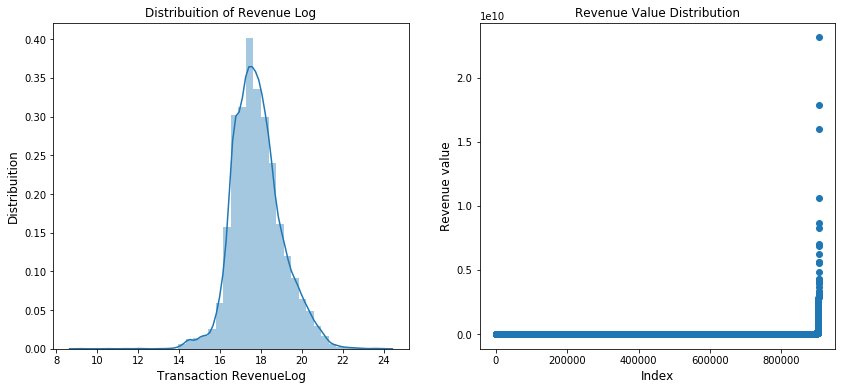

In [24]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)

ax = sns.distplot(
    np.log1p(train_df[train_df['totals.transactionRevenue'] > 0]['totals.transactionRevenue'] + 0.01), 
    bins=40, 
    kde=True
)
ax.set_xlabel('Transaction RevenueLog', fontsize=12) 
ax.set_ylabel('Distribuition', fontsize=12) 
ax.set_title('Distribuition of Revenue Log', fontsize=12) 

plt.subplot(1,2,2)

plt.scatter(range(train_df.shape[0]), np.sort(train_df['totals.transactionRevenue'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Revenue value', fontsize=12) 
plt.title('Revenue Value Distribution', fontsize=12) 

plt.show()

#### Date vs Revenue and Visits

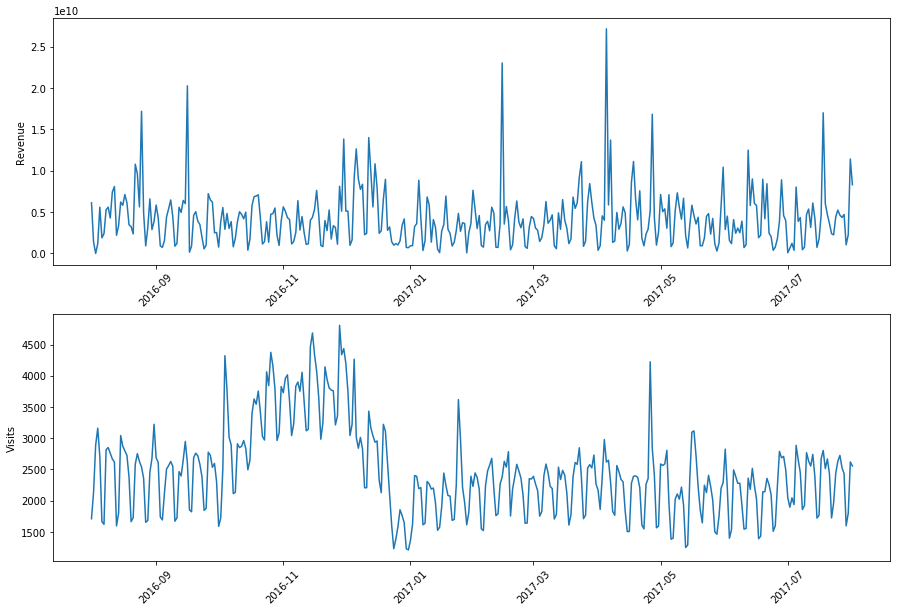

In [107]:
plot_df = train_df.groupby(by=['date']).agg({'fullVisitorId':'count', 'totals.transactionRevenue':'sum'}).reset_index()

fig = plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(pd.to_datetime(plot_df['date'].astype('str')), plot_df['totals.transactionRevenue'])
plt.ylabel('Revenue')
plt.xticks(rotation=90)

plt.subplot(2,1,2)
plt.plot(pd.to_datetime(plot_df['date'].astype('str')), plot_df['fullVisitorId'])
plt.ylabel('Visits')
plt.xticks(rotation=90);

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)


#### Visit Number vs Revenue Mean and Percent

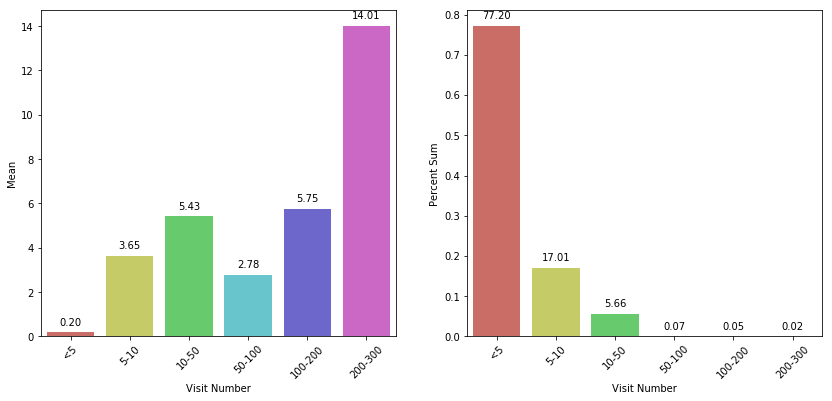

In [325]:
visitNum_df = train_df.groupby(by=['fullVisitorId']).agg({'visitNumber': 'count', 'totals.transactionRevenue': 'sum'})
visitNum_df['totals.transactionRevenue'] = np.log1p(visitNum_df['totals.transactionRevenue'])

total_revenue = visitNum_df['totals.transactionRevenue'].sum()

revenue_4 = visitNum_df[visitNum_df['visitNumber'] < 5]['totals.transactionRevenue']
reveune_5_9 = visitNum_df[(visitNum_df['visitNumber'] >= 5) & (visitNum_df['visitNumber'] < 10)]['totals.transactionRevenue']
revenue_10_49 = visitNum_df[(visitNum_df['visitNumber'] >= 10) & (visitNum_df['visitNumber'] < 50)]['totals.transactionRevenue']
revenue_50_99 = visitNum_df[(visitNum_df['visitNumber'] >= 50) & (visitNum_df['visitNumber'] < 100)]['totals.transactionRevenue']
revenue_100_199 = visitNum_df[(visitNum_df['visitNumber'] >= 100) & (visitNum_df['visitNumber'] < 200)]['totals.transactionRevenue']
revenue_200 = visitNum_df[visitNum_df['visitNumber'] >= 200]['totals.transactionRevenue']


mean_4 = np.mean(revenue_4)
mean_5_9 = np.mean(reveune_5_9)
mean_10_49 = np.mean(revenue_10_49)
mean_50_99 = np.mean(revenue_50_99)
mean_100_199 = np.mean(revenue_100_199)
mean_200 = np.mean(revenue_200)

sum_4 = revenue_4.sum() / total_revenue
sum_5_9 = reveune_5_9.sum() / total_revenue
sum_10_49 = revenue_10_49.sum() / total_revenue
sum_50_99 = revenue_50_99.sum() / total_revenue
sum_100_199 = revenue_100_199.sum() / total_revenue
sum_200 = revenue_200.sum() / total_revenue

obj_df = pd.DataFrame({ 
    'Visit Number': ['<5', '5-10', '10-50', '50-100', '100-200', '200-300'],
    'Mean': [mean_4, mean_5_9, mean_10_49, mean_50_99, mean_100_199, mean_200],
    'Percent Sum': [sum_4, sum_5_9, sum_10_49, sum_50_99, sum_100_199, sum_200]
})

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt = sns_bar_plot(plt, obj_df, 'Visit Number', 'Mean', 'Visit Number', 'Mean')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt = sns_bar_plot(plt, obj_df, 'Visit Number', 'Percent Sum', 'Visit Number', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Year Month, channelGrouping vs Percent Sum

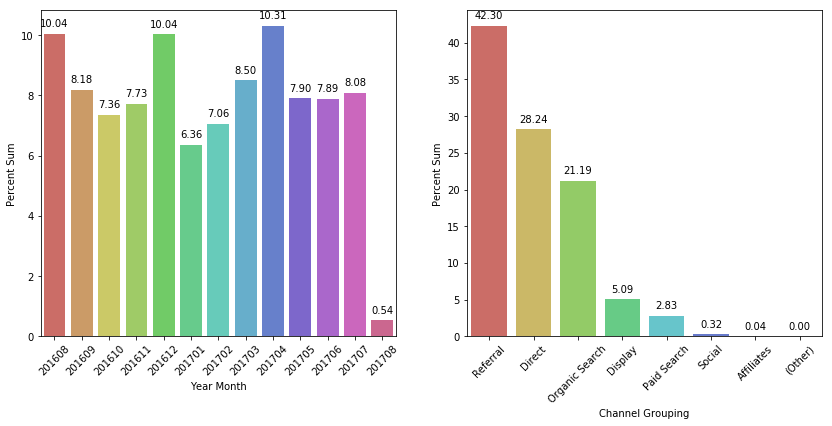

In [411]:
date_df = train_df.loc[:, ['date', 'totals.transactionRevenue']]

total_revenue = date_df['totals.transactionRevenue'].sum()

date_df['year_month'] = pd.to_datetime(date_df['date'].astype('str'), yearfirst=True).dt.strftime('%Y%m')

date_df = date_df.sort_values(by="year_month", ascending=True)
date_df = date_df.groupby(by=['year_month']).agg({'totals.transactionRevenue': 'sum'}).reset_index()
date_df['percent'] = (date_df['totals.transactionRevenue'] / total_revenue) * 100

channelGrouping_df = get_total_revenue('channelGrouping')

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt = sns_bar_plot(plt, date_df, 'year_month', 'percent', 'Year Month', 'Percent Sum')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt = sns_bar_plot(plt, channelGrouping_df, 'channelGrouping', 'percent', 'Channel Grouping', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Operating System, Device Operating System, Device Catefgory vs Percent Sum

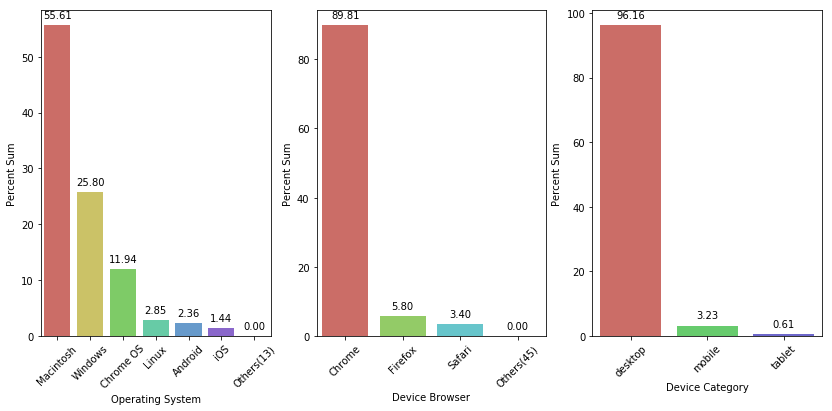

In [421]:
deviceOS_df = get_total_revenue('device.operatingSystem', True)
deviceBrowser_df = get_total_revenue('device.browser', True)
deviceCategory_df = get_total_revenue('device.deviceCategory')

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt = sns_bar_plot(plt, deviceOS_df, 'device.operatingSystem', 'percent', 'Operating System', 'Percent Sum')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
plt = sns_bar_plot(plt, deviceBrowser_df, 'device.browser', 'percent', 'Device Browser', 'Percent Sum')
plt.xticks(rotation=45)

plt.subplot(1,3,3)
plt = sns_bar_plot(plt, deviceCategory_df, 'device.deviceCategory', 'percent', 'Device Category', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Country vs Percent Sum

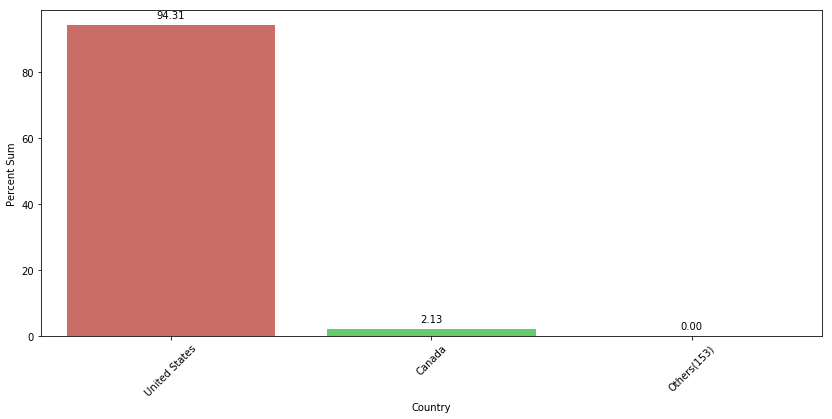

In [423]:
geoNetworkCountry_df = get_total_revenue('geoNetwork.country', True)

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, geoNetworkCountry_df, 'geoNetwork.country', 'percent', 'Country', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Traffic Source Medium vs percent Sum

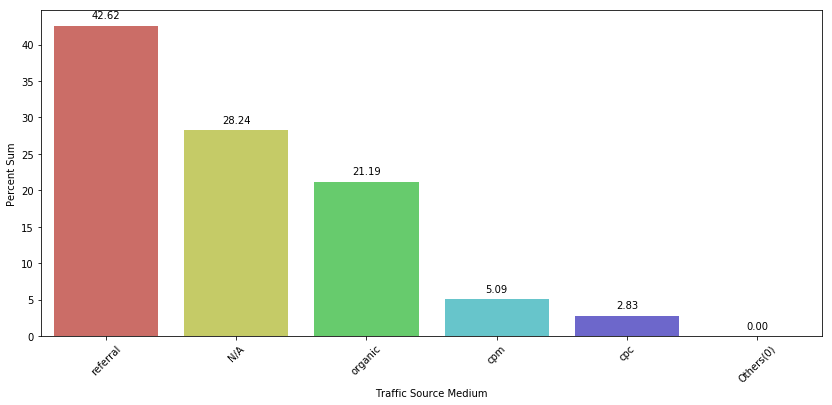

In [426]:
trafficMedium_df = get_total_revenue('trafficSource.medium', True)

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, trafficMedium_df, 'trafficSource.medium', 'percent', 'Traffic Source Medium', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Traffic Source Source vs percent Sum

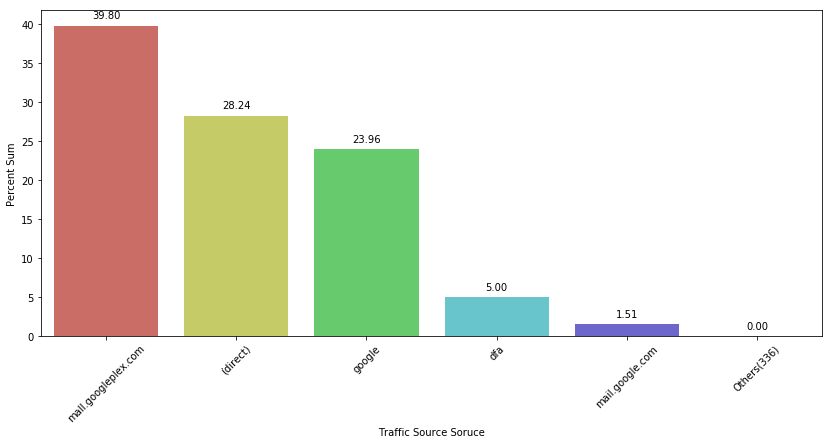

In [428]:
trafficSource_df = get_total_revenue('trafficSource.source', True)

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, trafficSource_df, 'trafficSource.source', 'percent', 'Traffic Source Soruce', 'Percent Sum')
plt.xticks(rotation=45)

plt.show()

#### Totals Hits vs percent Sum

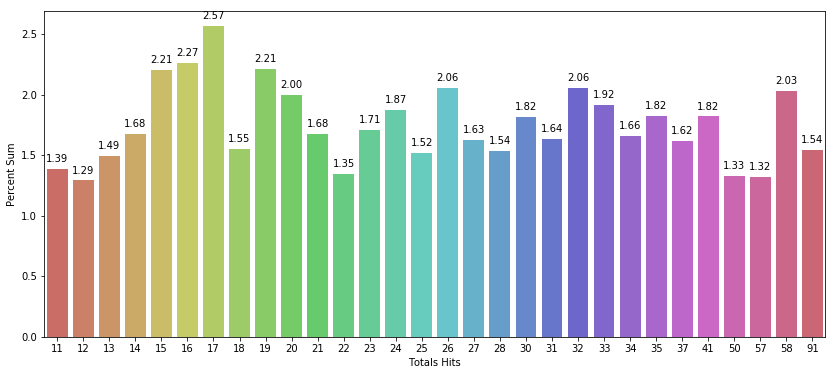

In [437]:
totalsHit_df = get_total_revenue('totals.hits', True)
totalsHit_df = totalsHit_df.sort_values(by='totals.transactionRevenue', ascending=False)[:30]

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, totalsHit_df, 'totals.hits', 'percent', 'Totals Hits', 'Percent Sum')

plt.show()

#### Totals New Visits vs percent Sum

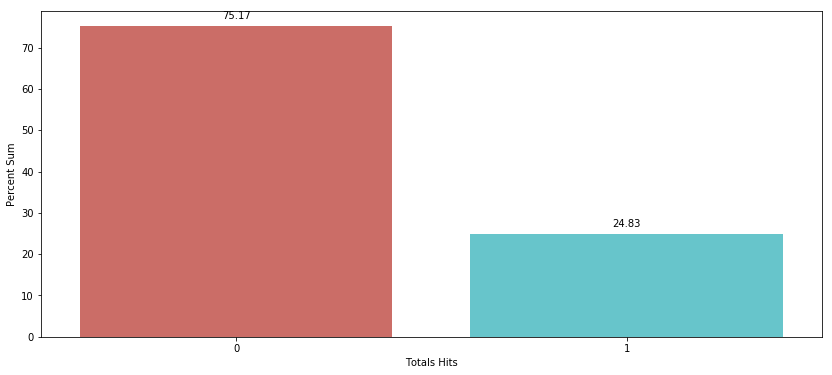

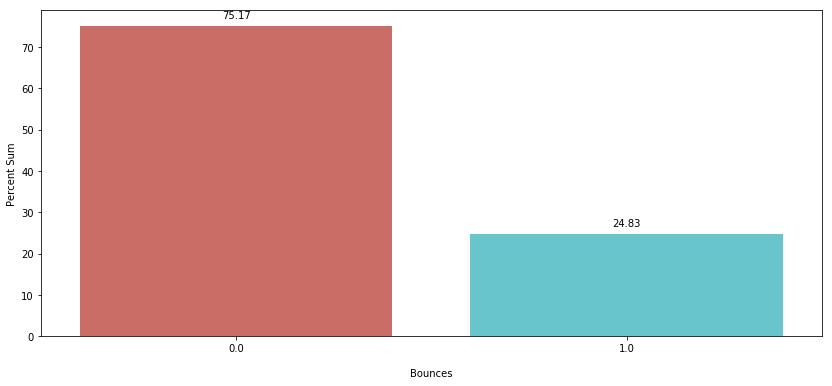

In [436]:
totalsNewVisits_df = get_total_revenue('totals.newVisits', False)

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, totalsNewVisits_df, 'totals.newVisits', 'percent', 'Totals New Visits', 'Percent Sum')

plt.show()

#### Totals Pageviews vs percent Sum

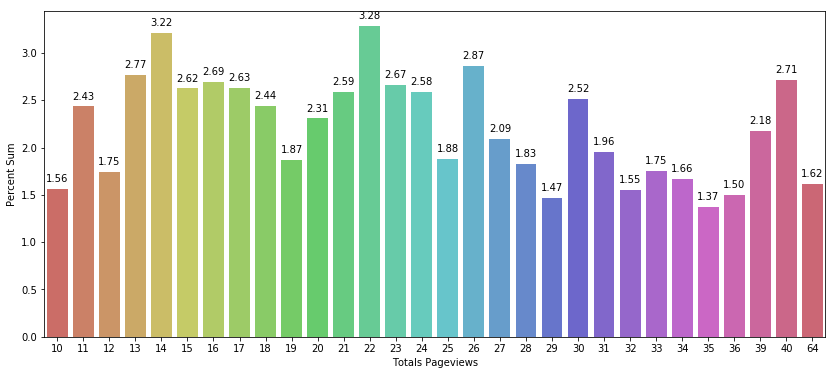

In [442]:
totalsPageviews_df = get_total_revenue('totals.pageviews', True)
totalsPageviews_df = totalsPageviews_df.sort_values(by='totals.transactionRevenue', ascending=False)[:30]

plt.figure(figsize=(14,6))
plt = sns_bar_plot(plt, totalsPageviews_df, 'totals.pageviews', 'percent', 'Totals Pageviews', 'Percent Sum')

plt.show()

### Normalizing Data

Now let us encode the features an normilize them so that the values are between 0 and 1. I will be using LabelEncoder from sklearn to encode the values. Then use MinMaxScaler to normalize the feature values between 0 and 1.

In [443]:
%%time

str_cols = [
    'channelGrouping', 'device.browser', 'device.deviceCategory', 'device.operatingSystem', 
    'geoNetwork.country', 'trafficSource.medium', 'trafficSource.source'
]

num_cols = [
    'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber'
]

feature_cols = str_cols + num_cols

train_core_df = train_df.loc[:, ['fullVisitorId', 'date', 'totals.transactionRevenue']]
train_revenue_df = train_df.loc[:, ['totals.transactionRevenue']]

test_core_df = test_df.loc[:, ['fullVisitorId', 'date']]

train_rest_df = train_df.loc[:, feature_cols]
test_rest_df = test_df.loc[:, feature_cols]

print('Encoding str_cols...')

for str_col in str_cols:
    labelEncoder = LabelEncoder()
    
    train_col_list = list(train_rest_df[str_col].astype('str'))
    test_col_list = list(test_rest_df[str_col].astype('str'))
    
    labelEncoder.fit(train_col_list + test_col_list)
    
    train_rest_df[str_col] = labelEncoder.transform(train_col_list)
    test_rest_df[str_col] = labelEncoder.transform(test_col_list)

print('Encoding num_cols...')

for num_col in num_cols:
    train_rest_df[num_col] = train_rest_df[num_col].astype('float')
    test_rest_df[num_col] = test_rest_df[num_col].astype('float')
    
minMaxScaler = MinMaxScaler()

print('Min Max Scalling train_df...')

normalized_train_df = pd.DataFrame(minMaxScaler.fit_transform(train_rest_df.astype('float')))
normalized_train_df.columns = train_rest_df.columns
normalized_train_df.index = train_rest_df.index

print('Min Max Scalling test_df...')

normalized_test_df = pd.DataFrame(minMaxScaler.transform(test_rest_df.astype('float')))
normalized_test_df.columns = test_rest_df.columns
normalized_test_df.index = test_rest_df.index

print()

Encoding str_cols...
Encoding num_cols...
Min Max Scalling train_df...
Min Max Scalling test_df...

CPU times: user 18.9 s, sys: 4.31 s, total: 23.2 s
Wall time: 27.3 s


In [444]:
normalized_train_df.describe()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.country,trafficSource.medium,trafficSource.source,totals.hits,totals.newVisits,totals.pageviews,visitNumber
count,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000,903653.0000000000
mean,0.6617524331,0.3641628231,0.1491850301,0.5434719820,0.7177953151,0.7230341735,0.5096656923,0.0072074902,0.7780198815,0.0060885659,0.0032103986
std,0.2535415747,0.1362235360,0.2630287940,0.3738189781,0.3053861596,0.3484297969,0.3336830116,0.0193215171,0.4155780752,0.0150105752,0.0235627779
min,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,0.5714285714,0.2844827586,0.0000000000,0.2608695652,0.4229074890,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
50%,0.5714285714,0.2844827586,0.0000000000,0.8695652174,0.9251101322,0.8000000000,0.4168336673,0.0020040080,1.0000000000,0.0000000000,0.0000000000
75%,1.0000000000,0.3879310345,0.5000000000,0.8695652174,0.9603524229,1.0000000000,0.8356713427,0.0060120240,1.0000000000,0.0064102564,0.0000000000
max,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000


In [445]:
cleaned_train_df = pd.concat([train_core_df, normalized_train_df], axis=1)

cleaned_train_df.head()

,fullVisitorId,date,totals.transactionRevenue,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.country,trafficSource.medium,trafficSource.source,totals.hits,totals.newVisits,totals.pageviews,visitNumber
0,1131660440785968503,20160902,0.0000000000,0.5714285714,0.2844827586,0.0000000000,0.8695652174,0.9251101322,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
1,377306020877927890,20160902,0.0000000000,0.5714285714,0.3534482759,0.0000000000,0.2608695652,0.0484581498,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
2,3895546263509774583,20160902,0.0000000000,0.5714285714,0.2844827586,0.0000000000,0.8695652174,0.8149779736,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
3,4763447161404445595,20160902,0.0000000000,0.5714285714,0.6724137931,0.0000000000,0.2173913043,0.4096916300,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
4,27294437909732085,20160902,0.0000000000,0.5714285714,0.2844827586,0.5000000000,0.0000000000,0.9559471366,0.8000000000,0.4168336673,0.0000000000,0.0000000000,0.0000000000,0.0025380711


In [446]:
normalized_test_df.describe()

,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.country,trafficSource.medium,trafficSource.source,totals.hits,totals.newVisits,totals.pageviews,visitNumber
count,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000,804684.0000000000
mean,0.6184674445,0.3568401406,0.2066382580,0.5052654750,0.7164030209,0.6850333796,0.4540103341,0.0064972467,0.7510650143,0.0053916796,0.0035890527
std,0.2379738553,0.1345381986,0.2869682078,0.3960511108,0.3068608249,0.3491887380,0.2991894126,0.0164268186,0.4323963355,0.0123624104,0.0239384192
min,0.0000000000,-0.0086206897,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,0.5714285714,0.2844827586,0.0000000000,0.2173913043,0.4096916300,0.4000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
50%,0.5714285714,0.2844827586,0.0000000000,0.2608695652,0.9515418502,0.8000000000,0.4168336673,0.0000000000,1.0000000000,0.0000000000,0.0000000000
75%,0.8571428571,0.3534482759,0.5000000000,0.8695652174,0.9603524229,1.0000000000,0.4509018036,0.0060120240,1.0000000000,0.0064102564,0.0000000000
max,1.0000000000,1.0948275862,1.0000000000,1.0000000000,0.9955947137,1.0000000000,0.9979959920,1.0000000000,1.0000000000,1.0662393162,1.1573604061


In [447]:
cleaned_test_df = pd.concat([test_core_df, normalized_test_df], axis=1)

cleaned_test_df.head()

,fullVisitorId,date,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.country,trafficSource.medium,trafficSource.source,totals.hits,totals.newVisits,totals.pageviews,visitNumber
0,6167871330617112363,20171016,0.5714285714,0.2844827586,0.0000000000,0.2608695652,0.7753303965,0.8000000000,0.4168336673,0.0060120240,0.0000000000,0.0064102564,0.0025380711
1,0643697640977915618,20171016,0.5714285714,0.2844827586,0.0000000000,0.8695652174,0.8149779736,0.8000000000,0.4168336673,0.0080160321,1.0000000000,0.0085470085,0.0000000000
2,6059383810968229466,20171016,0.5714285714,0.2844827586,0.0000000000,0.2608695652,0.2995594714,0.8000000000,0.4168336673,0.0120240481,1.0000000000,0.0128205128,0.0000000000
3,2376720078563423631,20171016,0.5714285714,0.6120689655,0.5000000000,1.0000000000,0.9603524229,0.8000000000,0.4168336673,0.0140280561,1.0000000000,0.0064102564,0.0000000000
4,2314544520795440038,20171016,0.5714285714,0.6120689655,0.0000000000,0.2608695652,0.9603524229,0.8000000000,0.4168336673,0.0160320641,1.0000000000,0.0064102564,0.0000000000


### Splitting Data

Now that we have normalized the data we need to split the dataset into development, validation. I will be splitting the data into 
- dev: 85% i.e, date ranges between 20160801 - 20170531
- val: 15% i.e. date ranges between 20170601 - 20170801

In [448]:
print('Transactions Minimum Date: {}'.format(cleaned_train_df['date'].min()))
print('Transactions Maximum Date: {}\n'.format(cleaned_train_df['date'].max()))

Transactions Minimum Date: 20160801
Transactions Maximum Date: 20170801



In [449]:
%%time

split_date = pd.datetime(2017, 6, 1)

cleaned_train_df['date'] = cleaned_train_df['date'].astype('str').apply(lambda x: parse(x, yearfirst=True))

dev_df = cleaned_train_df[cleaned_train_df['date'] < split_date]
val_df = cleaned_train_df[cleaned_train_df['date'] >= split_date]

feature_cols = ['fullVisitorId'] + str_cols + num_cols

dev_X = dev_df[['totals.transactionRevenue'] + feature_cols]
val_X = val_df[['totals.transactionRevenue'] + feature_cols]
test_X = cleaned_test_df[feature_cols]

print('\nNumber of instances in train: {} with {} columns.'.format(dev_X.shape[0], dev_X.shape[1]))
print('\nNumber of instances in val: {} with {} columns.'.format(val_X.shape[0], val_X.shape[1]))
print('\nNumber of instances in test: {} with {} columns.'.format(test_X.shape[0], test_X.shape[1]))
print()


Number of instances in train: 765707 with 13 columns.

Number of instances in val: 137946 with 13 columns.

Number of instances in test: 804684 with 12 columns.

CPU times: user 36.3 s, sys: 457 ms, total: 36.8 s
Wall time: 38.5 s


We now write these files in csv format so that we can use them in future

In [450]:
%%time

dev_X.to_csv(train_file, index=False, compression='zip')
val_X.to_csv(val_file, index=False, compression='zip')
test_X.to_csv(test_file, index=False, compression='zip')

CPU times: user 30.2 s, sys: 768 ms, total: 31 s
Wall time: 32.3 s
